In [1]:
#Load libraries
#pip install keybert[flair]
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import nltk
from nltk.util import ngrams


/home/aliciescont/anaconda3/envs/wid/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#load dataset
jobs_df = pd.read_csv('job_posts_clean_ish.csv')
jobs_df.head()

,Unnamed: 0,Date,Company,Title,Job Description,Criteria,Seniority,Employment Type,Job Function,Industry,Experience
0,0,2021-11-04,Dignity Health,Patient Advocate,*Overview*\n\nDignity Health Medical Foundatio...,Seniority level\nAssociate\nEmployment type\nF...,Associate,Full-time,Health Care Provider,"Nonprofit Organization Management, Health, Wel...",3.0
1,1,2021-11-04,Centene Corporation,Disease Management Enrollment Representative,Position Purpose\n\nThe Disease Management Enr...,Seniority level\nNot Applicable\nEmployment ty...,Not Applicable,Full-time,Customer Service and Information Technology,Hospital & Health Care and Insurance,3.0
2,2,2021-10-27,Dignity Health,Patient Logistics Coordinator,"*Overview*\n\nDignity Health, one of the natio...",Seniority level\nEntry level\nEmployment type\...,Entry level,Full-time,Management and Manufacturing,"Nonprofit Organization Management, Health, Wel...",2.0
3,3,2021-10-20,Centene Corporation,Disease Management Assistant (HNGS),Position Purpose\n\nThe Disease Management Ass...,Seniority level\nNot Applicable\nEmployment ty...,Not Applicable,Contract,Administrative,Hospital & Health Care and Insurance,3.0
4,4,2021-10-27,Dignity Health,Patient Logistics Coordinator,"*Overview*\n\nDignity Health, one of the natio...",Seniority level\nEntry level\nEmployment type\...,Entry level,Full-time,Management and Manufacturing,"Nonprofit Organization Management, Health, Wel...",2.0


In [3]:
jobs_df['Company'].value_counts()[:10]

Dignity Health               52
CommonSpirit Health          51
Centene Corporation          50
Zurich North America         23
Blue Shield of California    23
Magellan Health              21
gpac                         19
Great Clips Inc.             16
AutoZone                     16
Safeway                      15
Name: Company, dtype: int64

In [4]:
jobs_df['Job Description'][1]

'Position Purpose\n\nThe Disease Management Enrollment Representative contacts beneficiaries, stratifies, and refers them for enrollment into appropriate disease management programs. Duties include corresponding with beneficiaries and assessing their needs via telephone for placement into appropriate disease management programs. Additional responsibilities include managing incoming/outgoing phone calls, scheduling appointments and tracking data.\n\nContacts beneficiaries who have a diagnosed disease condition that has been determined to be uncontrolled; for example, patients who have been admitted to the hospital or have had multiple emergency room visits.\nWorks from unscripted talking points to obtain pertinent information regarding the beneficiary’s condition and assesses their readiness to make changes that will improve and control their disease. Guides the conversation to identify and work to overcome objections.\nRefers enrollees to the correct educator for enrollment into approp

In [5]:
def clean_job_desc(desc):
    desc_lower = desc.lower()
    desc_clean = re.sub(r"[\n\\']", " ", desc_lower)

    return desc_lower

In [6]:
#https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea
def get_keywords_ngram(text, model, ngram, n):
    """Extracts top n keywords from text using SentenceTransformer
    Inputs:
    text: original text
    ngram: tuple(n_min, n_max)
    model: refers to the model used for embedding using SentenceTransformer
    n: number of top keywords
    """
    #extract a list of candidates
    doc_vectorizer = CountVectorizer(ngram_range=ngram, stop_words='english').fit([text])
    doc_feat_names = doc_vectorizer.get_feature_names()
    #get embeddings
    emb_model = SentenceTransformer(model)
    doc_emb = emb_model.encode([text])
    keywords_emb = emb_model.encode(doc_feat_names)
    #filter the top keywords most similar to the document
    similarity = cosine_similarity(doc_emb, keywords_emb)
    top_kw_doc = [doc_feat_names[index] for index in similarity.argsort()[0][-n:]]
    top_kw_doc

    return top_kw_doc

In [7]:
doc = clean_job_desc(jobs_df['Job Description'][0])
keywords = get_keywords_ngram(doc,'all-distilroberta-v1', (3,3), 10)

In [8]:
keywords

['dignity health medical',
 'serve dignity health',
 'california dignity health',
 'affiliate dignity health',
 'medical foundation continues',
 'medical foundation affiliate',
 'medical foundation works',
 'foundation affiliate dignity',
 'medical foundation established',
 'health medical foundation']

It doesn't work for our case. Keywords extracted are too general. It needs to be trained with labeled data of 

## Education skills

In [9]:
#https://towardsdatascience.com/how-to-use-nlp-in-python-a-practical-step-by-step-example-bd82ca2d2e1e
education_dict = {'bs': 1, 'bachelor': 1, 'undergraduate': 1, 'diploma':0, 'high school':0, 'ged': 0, 'university':1, 'intern':1,'nursing':1, 'license':1,
               'master': 2, 'graduate': 2, 'mba': 2, 'associate':1,'phd': 2, 'ph.d': 2, 'ba': 1, 'ma': 2,
               'postdoctoral': 3, 'postdoc': 3, 'doctorate': 2, 'advanced degree': 2, 'ms or': 2, 'ms degree': 2, '4 year degree': 1, 'bs/': 1, 'ba/': 1,
                '4-year degree': 1, 'b.s.': 1, 'm.s.': 2, 'm.s': 2, 'b.s': 1, 'phd/': 3, 'ph.d.': 3, 'ms/': 2,
                'm.s/': 2, 'm.s./': 2, 'msc/': 2, 'master/': 2, 'master\'s/': 2, 'bachelor\s/': 1}

In [10]:

ps = PorterStemmer()

def stem_job_desc(desc):
    tokens = word_tokenize(desc)
    token_tag = pos_tag(tokens)
    
    include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']

    filtered_tokens = [tok for tok, tag in token_tag if tag in include_tags ]

    stemmed_tokens = [ps.stem(tok).lower() for tok in filtered_tokens]

    return set(stemmed_tokens)


In [11]:
education_keywords = set([ps.stem(tok) for tok in education_dict.keys()])
education_keywords_dict = {ps.stem(tok):tok for tok in education_dict.keys()}

In [12]:
jobs_df['desc_stem'] = jobs_df['Job Description'].map(stem_job_desc)


In [13]:
jobs_df['desc_stem'][1]

{'addit',
 'adjud',
 'admit',
 'appli',
 'applic',
 'appoint',
 'appropri',
 'associ',
 'base',
 'been',
 'beneficiari',
 'busi',
 'call',
 'care',
 'centen',
 'chang',
 'characterist',
 'citizenship',
 'clear',
 'clinic',
 'color',
 'commit',
 'condit',
 'consider',
 'contact',
 'contract',
 'convers',
 'correct',
 'coursework',
 'custom',
 'data',
 'defens',
 'degre',
 'depart',
 'desir',
 'determin',
 'develop',
 'diagnos',
 'differ',
 'disabl',
 'diseas',
 'divers',
 'duti',
 'educ',
 'education/experi',
 'emerg',
 'employ',
 'enrol',
 'equal',
 'exampl',
 'experi',
 'favor',
 'feder',
 'field',
 'form',
 'gender',
 'gener',
 'govern',
 'had',
 'health',
 'higher',
 'hospit',
 'ident',
 'inform',
 'intent',
 'law',
 'learn',
 'level',
 'manag',
 'minimum',
 'multipl',
 'nation',
 'necessari',
 'need',
 'object',
 'opportun',
 'orient',
 'origin',
 'other',
 'patient',
 'pertin',
 'phone',
 'place',
 'placement',
 'point',
 'posit',
 'prefer',
 'program',
 'proof',
 'protect',
 'pro

In [14]:
education_list = []

for i in range(len(jobs_df['Job Description'])):
    job_desc = jobs_df['Job Description'][i].lower() 
    
    job_desc_set = jobs_df.iloc[i]['desc_stem'] 
   
    education_words = education_keywords.intersection(job_desc_set)
    
    min_education_level = 999

    for edu_word in education_words:
        level = education_dict[education_keywords_dict[edu_word]]
        min_education_level = min(min_education_level, level)
        
    if min_education_level > 500:
        if 'degree' in job_desc:
            min_education_level = 1

    education_list.append(min_education_level)


In [15]:
jobs_df['degree_value'] = education_list
jobs_df.loc[jobs_df['degree_value'] == 0, 'degree_type'] = 'high school'
jobs_df.loc[jobs_df['degree_value'] == 1, 'degree_type'] = 'bachelors'
#graduated label includes (Masters, PhD, postdoc)
jobs_df.loc[jobs_df['degree_value'] == 2, 'degree_type'] = 'graduated'
jobs_df.loc[jobs_df['degree_value'] > 500, 'degree_type'] = 'not_specified'



<AxesSubplot:>

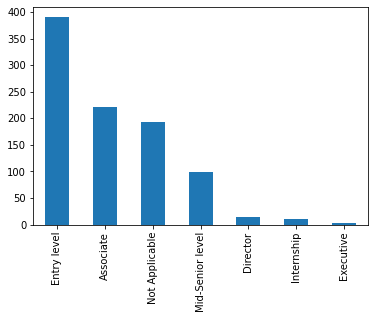

In [16]:
jobs_df['Seniority'].value_counts(sort = False).sort_values(ascending=False).plot.bar()

## EDA

In [17]:
#check if there is nan values
jobs_df.isna().sum()

Unnamed: 0          0
Date                0
Company             0
Title               0
Job Description     0
Criteria            0
Seniority          17
Employment Type     0
Job Function       17
Industry           16
Experience         95
desc_stem           0
degree_value        0
degree_type         0
dtype: int64

In [18]:
#check mean years of experience related to each dataset
jobs_df[['Experience', 'Seniority']].groupby('Seniority').mean()

,Experience
Seniority,
Associate,3.895522
Director,4.857143
Entry level,3.423423
Executive,5.000000
Internship,2.888889
Mid-Senior level,4.736264
Not Applicable,3.301587


In [19]:
#assigned years of experience related to 
jobs_df.loc[(jobs_df['Experience'].isna() == True) & (jobs_df['Seniority'] == 'Internship'), 'Experience'] = 2
jobs_df.loc[(jobs_df['Experience'].isna() == True) & (jobs_df['Seniority'] == 'Entry level'), 'Experience'] = 3
jobs_df.loc[(jobs_df['Experience'].isna() == True) & (jobs_df['Seniority'] == 'Associate'), 'Experience'] = 4
jobs_df.loc[(jobs_df['Experience'].isna() == True) & (jobs_df['Seniority'] == 'Mid-Senior level'), 'Experience'] = 5
jobs_df.loc[(jobs_df['Experience'].isna() == True) & (jobs_df['Seniority'] == 'Mid-Senior level'), 'Experience'] = 5


In [20]:
#check nan after imputation
jobs_df.isna().sum()/len(jobs_df)*100

Unnamed: 0         0.000000
Date               0.000000
Company            0.000000
Title              0.000000
Job Description    0.000000
Criteria           0.000000
Seniority          1.793249
Employment Type    0.000000
Job Function       1.793249
Industry           1.687764
Experience         0.843882
desc_stem          0.000000
degree_value       0.000000
degree_type        0.000000
dtype: float64

In [21]:
#drop rest of nan values and check 
jobs_df = jobs_df.dropna()
jobs_df.isna().sum()

Unnamed: 0         0
Date               0
Company            0
Title              0
Job Description    0
Criteria           0
Seniority          0
Employment Type    0
Job Function       0
Industry           0
Experience         0
desc_stem          0
degree_value       0
degree_type        0
dtype: int64

In [22]:
jobs_df['Seniority'].sort_values(ascending=False).value_counts()/len(jobs_df)*100

Entry level         42.116631
Associate           23.866091
Not Applicable      20.410367
Mid-Senior level    10.691145
Director             1.511879
Internship           1.187905
Executive            0.215983
Name: Seniority, dtype: float64

In [23]:
#check the difference between Director and Executive
set(jobs_df['Experience'][jobs_df['Seniority'] == 'Director'])

{3.0, 4.0, 5.0, 8.0}

In [24]:
#assigned Director and Exucutive same level, since there are few levels.Categorical(jobs_df['Seniority'])
jobs_df.loc[(jobs_df['Seniority'] == 'Director') | (jobs_df['Seniority'] == 'Executive') , 'Seniority'] = 'Director & Executive'

In [25]:
jobs_df['Seniority'].sort_values(ascending=False).value_counts()/len(jobs_df)*100

Entry level             42.116631
Associate               23.866091
Not Applicable          20.410367
Mid-Senior level        10.691145
Director & Executive     1.727862
Internship               1.187905
Name: Seniority, dtype: float64

Associate and entry levels are supposed to be for people with less than 3 years of experience. Therefore, most of the jobs posted are aimed to people with less than 3-4 years experience

Data quality issues: 20% of the data is not labeled by any Seniority type 

In [26]:
#mean experience for jobs labeled as NA
na_seniority = jobs_df[['degree_type', 'Experience', 'Industry', 'Employment Type', 'Job Function']][jobs_df['Seniority']=='Not Applicable']
na_seniority.groupby('degree_type').mean()

,Experience
degree_type,
bachelors,3.409449
graduated,6.500000
high school,2.978723
not_specified,2.923077


In [27]:
#Job function for jobs labeled as NA
na_seniority['Job Function'].value_counts()[:10]

Health Care Provider                                  35
Management and Manufacturing                          20
Engineering and Information Technology                17
Other                                                 16
Information Technology                                15
Sales and Business Development                        13
Customer Service and Information Technology           11
Project Management and Information Technology         10
General Business, Finance, and Accounting/Auditing     7
Finance and Sales                                      7
Name: Job Function, dtype: int64

<AxesSubplot:xlabel='degree_type', ylabel='count'>

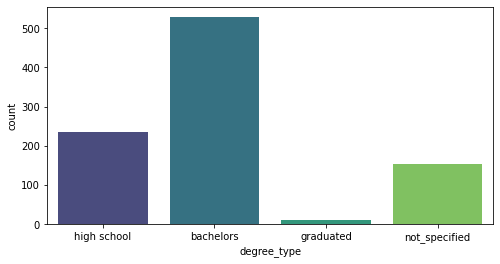

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(x='degree_type', data = jobs_df, order = ['high school', 'bachelors', 'graduated', 'not_specified'], palette='viridis')

In [29]:
jobs_df.sort_values('degree_value', ascending = False)['degree_type'].value_counts()


bachelors        529
high school      236
not_specified    152
graduated          9
Name: degree_type, dtype: int64

<AxesSubplot:xlabel='Seniority', ylabel='count'>

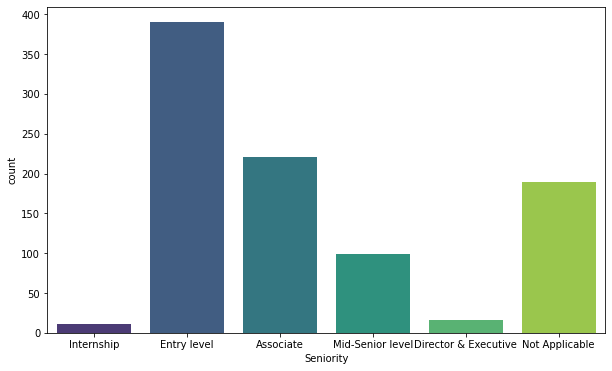

In [30]:

seniority_order = ['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director & Executive', 'Not Applicable']
plt.figure(figsize=(10,6))
sns.countplot(x='Seniority', data = jobs_df, order = seniority_order, palette='viridis')


In [31]:
jobs_df['Seniority'].value_counts()

Entry level             390
Associate               221
Not Applicable          189
Mid-Senior level         99
Director & Executive     16
Internship               11
Name: Seniority, dtype: int64

The 

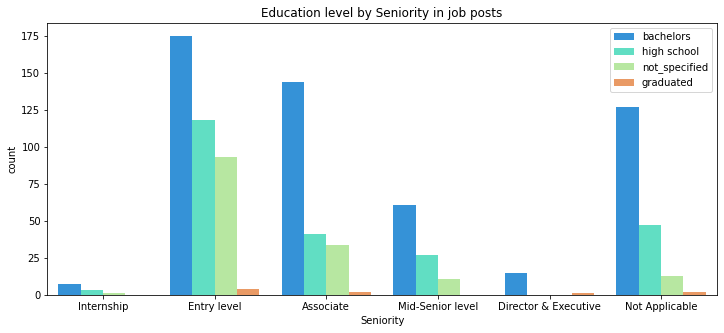

In [32]:
plt.figure(figsize=(12,5))
sns.countplot(x='Seniority', data = jobs_df, order = seniority_order, hue='degree_type', palette='rainbow')
plt.legend(loc='upper right')
plt.title('Education level by Seniority in job posts')
plt.savefig('educaction_seniority.png')

<AxesSubplot:xlabel='Seniority', ylabel='Experience'>

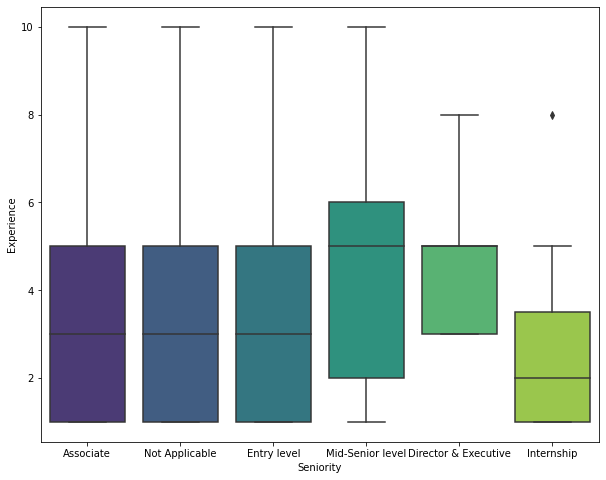

In [33]:
plt.figure(figsize=(10,8))
sns.boxplot(data=jobs_df, x='Seniority', y='Experience', palette='viridis')

In [34]:
#change categorical values to numerical values to calculate correlation
jobs_df_cat = jobs_df.copy()
jobs_df['Criteria'] = jobs_df['Criteria'].astype('category')
jobs_df['Seniority'] = jobs_df['Seniority'].astype('category')
jobs_df['Employment Type'] = jobs_df['Employment Type'].astype('category')
jobs_df['Job Function'] = jobs_df['Job Function'].astype('category')
jobs_df['Industry'] = jobs_df['Industry'].astype('category')


jobs_df_cat['Criteria_cat'] = jobs_df['Criteria'].cat.codes
jobs_df_cat['Seniority_cat'] = jobs_df['Criteria'].cat.codes
jobs_df_cat['Employment_type_cat'] = jobs_df['Employment Type'].cat.codes
jobs_df_cat['Job Function_cat'] = jobs_df['Job Function'].cat.codes
jobs_df_cat['Industry_cat'] = jobs_df['Industry'].cat.codes
jobs_df_cat.head()

,Unnamed: 0,Date,Company,Title,Job Description,Criteria,Seniority,Employment Type,Job Function,Industry,Experience,desc_stem,degree_value,degree_type,Criteria_cat,Seniority_cat,Employment_type_cat,Job Function_cat,Industry_cat
0,0,2021-11-04,Dignity Health,Patient Advocate,*Overview*\n\nDignity Health Medical Foundatio...,Seniority level\nAssociate\nEmployment type\nF...,Associate,Full-time,Health Care Provider,"Nonprofit Organization Management, Health, Wel...",3.0,"{care, vital, persuas, new, demonstr, word, in...",1,bachelors,55,55,1,30,136
1,1,2021-11-04,Centene Corporation,Disease Management Enrollment Representative,Position Purpose\n\nThe Disease Management Enr...,Seniority level\nNot Applicable\nEmployment ty...,Not Applicable,Full-time,Customer Service and Information Technology,Hospital & Health Care and Insurance,3.0,"{need, learn, care, centen, sf86, veteran, tel...",1,bachelors,476,476,1,12,88
2,2,2021-10-27,Dignity Health,Patient Logistics Coordinator,"*Overview*\n\nDignity Health, one of the natio...",Seniority level\nEntry level\nEmployment type\...,Entry level,Full-time,Management and Manufacturing,"Nonprofit Organization Management, Health, Wel...",2.0,"{core, need, approach, care, vision, 400, tele...",1,bachelors,289,289,1,38,136
3,3,2021-10-20,Centene Corporation,Disease Management Assistant (HNGS),Position Purpose\n\nThe Disease Management Ass...,Seniority level\nNot Applicable\nEmployment ty...,Not Applicable,Contract,Administrative,Hospital & Health Care and Insurance,3.0,"{need, dm/cm/um, care, third, centen, sf86, ve...",0,high school,465,465,0,5,88
4,4,2021-10-27,Dignity Health,Patient Logistics Coordinator,"*Overview*\n\nDignity Health, one of the natio...",Seniority level\nEntry level\nEmployment type\...,Entry level,Full-time,Management and Manufacturing,"Nonprofit Organization Management, Health, Wel...",2.0,"{core, need, approach, care, vision, 400, tele...",1,bachelors,289,289,1,38,136


In [35]:
jobs_final = jobs_df_cat[['Date', 'Experience', 'degree_value', 'Criteria_cat', 'Seniority_cat', 'Employment_type_cat', 'Job Function_cat', 'Industry_cat']]
jobs_final.head()

,Date,Experience,degree_value,Criteria_cat,Seniority_cat,Employment_type_cat,Job Function_cat,Industry_cat
0,2021-11-04,3.0,1,55,55,1,30,136
1,2021-11-04,3.0,1,476,476,1,12,88
2,2021-10-27,2.0,1,289,289,1,38,136
3,2021-10-20,3.0,0,465,465,0,5,88
4,2021-10-27,2.0,1,289,289,1,38,136


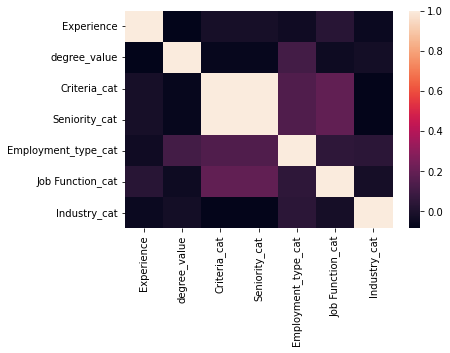

In [36]:
plt.figure(figsize=(6,4))
corr = jobs_final.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('corr.png')

## Skills

In [37]:
skills_df = pd.read_csv('linkedin_ec_graph_may_2021.csv')
top_skills = skills_df['categoryName'][skills_df['categoryType']== 'Top Trending Skills'].to_list()

In [38]:
top_skills

['JavaScript',
 'Account Management',
 'Sales Management',
 'Investment Properties',
 'Working with First-Time Home Buyers',
 'Operations Management',
 'Team Building',
 'Legal Writing',
 'Construction Management',
 'Civil Litigation',
 'Account Reconciliation',
 'Sales Operations',
 'General Ledger',
 'Customer Satisfaction',
 'Nursing',
 'Basic Life Support (BLS)']

In [39]:
#convert top skills list to a stem dictionary
skill_keywords = set([ps.stem(tok) for tok in top_skills])
skill_keywords_dict = {ps.stem(tok):tok for tok in top_skills}
skill_keywords_dict

{'javascript': 'JavaScript',
 'account manag': 'Account Management',
 'sales manag': 'Sales Management',
 'investment properti': 'Investment Properties',
 'working with first-time home buy': 'Working with First-Time Home Buyers',
 'operations manag': 'Operations Management',
 'team build': 'Team Building',
 'legal writ': 'Legal Writing',
 'construction manag': 'Construction Management',
 'civil litig': 'Civil Litigation',
 'account reconcili': 'Account Reconciliation',
 'sales oper': 'Sales Operations',
 'general ledg': 'General Ledger',
 'customer satisfact': 'Customer Satisfaction',
 'nurs': 'Nursing',
 'basic life support (bls)': 'Basic Life Support (BLS)'}

In [40]:
skills_df.head()

,date,countryCode,countryName,regionName,industryName,categoryType,categoryName,categoryValue,rank
0,2021-05-31,us,United States,Greater Sacramento,All,Top Trending Employers,UC Davis Health,5.304170,1
1,2021-05-31,us,United States,Greater Sacramento,All,Top Trending Employers,"University of California, Davis",2.124697,2
2,2021-05-31,us,United States,Greater Sacramento,All,Top Trending Employers,Intel Corporation,1.907629,3
3,2021-05-31,us,United States,Greater Sacramento,All,Top Trending Employers,Pacific Gas and Electric Company,6.240319,4
4,2021-05-31,us,United States,Greater Sacramento,All,Top Trending Employers,Sutter Health,1.461146,5


In [43]:
def bigram_clean(text):
    
    clean_job = re.sub(r"[^a-zA-Z]", " ", text)

    tokenized = clean_job.lower().split()
    tokenized_clean = [ps.stem(tok).lower() for tok in tokenized]

    Bigrams = ngrams(tokenized_clean, 2)

    bigrams_job = [(' ').join(gram) for gram in Bigrams]
    
    return bigrams_job

In [45]:
new_skill_df = jobs_df[['Title']]
new_skill_df['Bigrams']= jobs_df['Job Description'].map(lambda x : bigram_clean(x))
skill_columns = skill_keywords_dict.keys()
for col in skill_columns:
    
    if len(col.split()) == 1:
        new_skill_df[col] = jobs_df['desc_stem'].map(lambda x : list(x).count(col))
    elif len(col) >= 2:
        new_skill_df[col] = new_skill_df['Bigrams'].map(lambda x : list(x).count('account manag'))

    



/tmp/ipykernel_58301/606401578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_skill_df['Bigrams']= jobs_df['Job Description'].map(lambda x : bigram_clean(x))
/tmp/ipykernel_58301/606401578.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_skill_df[col] = jobs_df['desc_stem'].map(lambda x : list(x).count(col))
/tmp/ipykernel_58301/606401578.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [58]:
new_skill_df.head()

,Title,Bigrams,JavaScript,Account Management,Sales Management,Investment Properties,Working with First-Time Home Buyers,Operations Management,Team Building,Legal Writing,Construction Management,Civil Litigation,Account Reconciliation,Sales Operations,General Ledger,Customer Satisfaction,Nursing,Basic Life Support (BLS)
0,Patient Advocate,"[overview digniti, digniti health, health medi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Disease Management Enrollment Representative,"[posit purpos, purpos the, the diseas, diseas ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Patient Logistics Coordinator,"[overview digniti, digniti health, health one,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Disease Management Assistant (HNGS),"[posit purpos, purpos the, the diseas, diseas ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Patient Logistics Coordinator,"[overview digniti, digniti health, health one,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
list(skill_columns)[1:]

['account manag',
 'sales manag',
 'investment properti',
 'working with first-time home buy',
 'operations manag',
 'team build',
 'legal writ',
 'construction manag',
 'civil litig',
 'account reconcili',
 'sales oper',
 'general ledg',
 'customer satisfact',
 'nurs',
 'basic life support (bls)']

In [53]:
plot_dict = dict()
for col in list(skill_columns)[1:]:
    plot_dict[col] = sum(new_skill_df[col])


<BarContainer object of 15 artists>

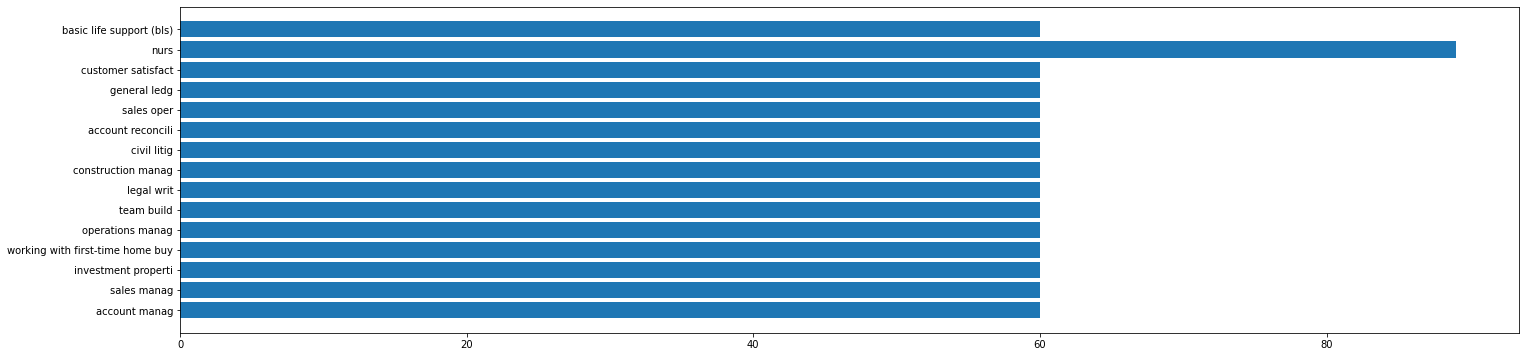

In [54]:
plt.figure(figsize=(24,6))
plt.barh(*zip(*plot_dict.items()))

In [55]:
columns_name = list(skill_keywords_dict.values())
columns_name

['JavaScript',
 'Account Management',
 'Sales Management',
 'Investment Properties',
 'Working with First-Time Home Buyers',
 'Operations Management',
 'Team Building',
 'Legal Writing',
 'Construction Management',
 'Civil Litigation',
 'Account Reconciliation',
 'Sales Operations',
 'General Ledger',
 'Customer Satisfaction',
 'Nursing',
 'Basic Life Support (BLS)']

In [56]:
new_skill_df = new_skill_df.rename(columns= skill_keywords_dict)
new_skill_df.head()

,Title,Bigrams,JavaScript,Account Management,Sales Management,Investment Properties,Working with First-Time Home Buyers,Operations Management,Team Building,Legal Writing,Construction Management,Civil Litigation,Account Reconciliation,Sales Operations,General Ledger,Customer Satisfaction,Nursing,Basic Life Support (BLS)
0,Patient Advocate,"[overview digniti, digniti health, health medi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Disease Management Enrollment Representative,"[posit purpos, purpos the, the diseas, diseas ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Patient Logistics Coordinator,"[overview digniti, digniti health, health one,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Disease Management Assistant (HNGS),"[posit purpos, purpos the, the diseas, diseas ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Patient Logistics Coordinator,"[overview digniti, digniti health, health one,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
